In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [51]:
import os
import random
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain, product

### Prepare data

In [3]:
SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
              'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
              'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
              'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
              'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)

In [43]:
DOC_LEN = 5
SENT_FROM_LEN = 5
SENT_TO_LEN = 15
CTX_LEN = ((SENT_TO_LEN-SENT_FROM_LEN)//2)*DOC_LEN

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_rand_sent_code(sem_type, sent_len):
    return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs
    
# def batch_mixture(doc_a, doc_b, doc_mix, k):
#     batch_x1, batch_x2, batch_ctx, batch_y = [], [], [], []
#     ys = [1,0,0,1]
#     doc_mix_flat = list(chain.from_iterable(doc_mix))
#     doc_mix_len = len(doc_mix_flat)
#     doc_mix_padded = np.array(doc_mix_flat[:CTX_LEN]) if doc_mix_len>=CTX_LEN else np.array(doc_mix_flat+[0]*(CTX_LEN-doc_mix_len))
#     for _ in range(k):
#         for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
#             batch_x1.append(random.choice(da))
#             batch_x2.append(random.choice(db))
#             batch_y.append(ys[i])
#     return batch(batch_x1), batch(batch_x2), batch([doc_mix_padded]), np.array(batch_y)

# def get_batch(n=40):
#     if n%4!=0:
#         raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
#     type1, type2 = np.random.choice(TYPES, 2, replace=False)
#     doc_a, doc_b, doc_mix, _ = get_mixture(type1, type2) # document labels isn't germane here.
#     (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), (batch_ctx,batch_ctx_len), batch_y = \
#                                                                 batch_mixture(doc_a,doc_b,doc_mix,n//4)
#     return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_ctx,batch_ctx_len,batch_y

def batch_mixture(doc_a, doc_b, k):
    batch_x1, batch_x2, batch_y = [], [], []
    ys = [1,0,0,1]
    for _ in range(k):
        for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
            batch_x1.append(random.choice(da))
            batch_x2.append(random.choice(db))
            batch_y.append(ys[i])
    return batch_x1, batch_x2, batch_y

def get_batch(n=40):
    if n%4!=0:
        raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    doc_a, doc_b, doc_mix, _ = get_mixture(type1, type2) # document labels isn't germane here.
    batch_x1, batch_x2, batch_y = batch_mixture(doc_a,doc_b,n//4)
    return batch_x1, batch_x2, batch_y

### Mutual attention

In [42]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

input_x1 = tf.placeholder(tf.int32, [None, 1], name='input_x1') # <max-time, batch-size>
input_x2 = tf.placeholder(tf.int32, [None, 1], name='input_x2')
input_x1_length = tf.placeholder(tf.int32, [1], name='input_x1_length')
input_x2_length = tf.placeholder(tf.int32, [1], name='input_x2_length')
input_y  = tf.placeholder(tf.int32, [1], name='input_y')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

with tf.variable_scope('Embeddings'):
    embeddings = tf.get_variable('embeddings', [VOCAB_SIZE, EMB_SIZE], 
                                 initializer=tf.contrib.layers.xavier_initializer())
    input_x1_embedded = tf.nn.embedding_lookup(embeddings, input_x1) # <max-time, batch-size, emb-size>
    input_x2_embedded = tf.nn.embedding_lookup(embeddings, input_x2)
    
cell = DropoutWrapper(LSTMCell(HID_SIZE),output_keep_prob=keep_prob)
    
def run_sent_lstm(cell, inputs, inputs_length):
    ((fw_outputs,bw_outputs), # <max-time, batch-size, hid-size>, attention later if needed.
     (fw_final_state,bw_final_state)) = ( # <batch-size, hid-size>
        tf.nn.bidirectional_dynamic_rnn(cell_fw=cell,
                                        cell_bw=cell,
                                        inputs=inputs,
                                        sequence_length=inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    return tf.concat([fw_final_state.h,bw_final_state.h], 1), \
           tf.squeeze(tf.concat([fw_outputs,bw_outputs], 2), 1)
        # op1: <batch-size, hid-size*2>
        # op2: <max-time, batch-size, hid-size*2> -> <max-time, hid-size*2>
        # NB: batch-size = 1 here.

with tf.variable_scope('Bi-LSTM') as scope:
    final_state_x1, outputs_x1 = run_sent_lstm(cell, input_x1_embedded, input_x1_length)
    scope.reuse_variables() # both sentence inputs share the same weights.
    final_state_x2, outputs_x2 = run_sent_lstm(cell, input_x2_embedded, input_x2_length)

def run_attention(d_mat, s_vec):
    W_d = tf.get_variable('W_d', [HID_SIZE*2, HID_SIZE*2], initializer=tf.contrib.layers.xavier_initializer())
    W_s = tf.get_variable('W_s', [HID_SIZE*2, HID_SIZE*2], initializer=tf.contrib.layers.xavier_initializer())
    d_W = tf.matmul(d_mat, W_d) # <max-time,20> * <20,20> = <max-time,20>
    s_W = tf.squeeze(tf.matmul(s_vec, W_s), 0) # <1,20> * <20,20> = <1,20> -> <20,>
    a_mat = tf.nn.tanh(tf.add(d_W, s_W)) # <max-time,20>
    W_a = tf.get_variable('W_a', [HID_SIZE*2, 1], initializer=tf.contrib.layers.xavier_initializer()) # <20,1>
    a_W = tf.transpose(tf.matmul(a_mat, W_a), [1,0]) # <1,max-time>
    d_a = tf.matmul(a_W, d_mat) # <1,20>
    return d_a

with tf.variable_scope('Mutual-Attention') as scope:
    x1_to_x2_attvec = run_attention(outputs_x2, final_state_x1) # x1 attending to x2
    scope.reuse_variables()
    x2_to_x1_attvec = run_attention(outputs_x1, final_state_x2) # x2 attending to x1
    
def run_scores(fs_x1, fs_x2, av_12, av_21):
    W_bi = tf.get_variable('W_bi', [HID_SIZE*4, HID_SIZE*4], initializer=tf.contrib.layers.xavier_initializer())
    fv_x1 = tf.concat([fs_x1,av_12],axis=1) # <1,40>
    fv_x2 = tf.concat([fs_x2,av_21],axis=1)
    return tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(fv_x1,W_bi),tf.transpose(fv_x2))),name='scores')

scores = run_scores(final_state_x1, final_state_x2, x1_to_x2_attvec, x2_to_x1_attvec)
predictions = tf.cast(tf.round(scores), tf.int32, name='predictions') 

with tf.name_scope('Loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses)

with tf.name_scope('Accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-5)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step, name='train_op')

sess.run(tf.global_variables_initializer())

In [58]:
NUM_EPOCHS = 50
NUM_BATCHES = 1000
VERBOSE = 100

try:
    loss_track, accuracy_track = [], []
    for e in range(NUM_EPOCHS):
        print('Epoch ', e+1)
        print('\n')
        curr_loss_track, curr_accuracy_track = [], []
        for _ in range(NUM_BATCHES):
            batch_x1, batch_x2, batch_y = get_batch()
            for x1, x2, y in zip(batch_x1,batch_x2,batch_y):
                x1,x1_len = batch([x1])
                x2,x2_len = batch([x2])
                y = [y]
                fd = {input_x1:x1, input_x1_length:x1_len,
                      input_x2:x2, input_x2_length:x2_len,
                      input_y:y,
                      keep_prob:KEEP_PROB}
                _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
                curr_loss_track.append(loss_)
                curr_accuracy_track.append(accuracy_)
                if step%VERBOSE==0:
                    print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, np.mean(curr_loss_track), 
                                                                                      np.mean(curr_accuracy_track)))
            loss_track += curr_loss_track
            accuracy_track += curr_accuracy_track
except KeyboardInterrupt:
    print('Stopped!')            

Epoch  1


  batch loss & accuracy at step 423500: <0.5032082796096802, 1.0>
  batch loss & accuracy at step 423600: <0.5042983293533325, 1.0>
  batch loss & accuracy at step 423700: <0.5061130523681641, 0.9964788556098938>
  batch loss & accuracy at step 423800: <0.5115534663200378, 0.984375>
  batch loss & accuracy at step 423900: <0.5098389387130737, 0.9876033067703247>
  batch loss & accuracy at step 424000: <0.5089454054832458, 0.9897260069847107>
  batch loss & accuracy at step 424100: <0.5081626772880554, 0.9912280440330505>
  batch loss & accuracy at step 424200: <0.5080155730247498, 0.9910714030265808>
  batch loss & accuracy at step 424300: <0.507568895816803, 0.9920814633369446>
  batch loss & accuracy at step 424400: <0.5086782574653625, 0.9888211488723755>
  batch loss & accuracy at step 424500: <0.5087453722953796, 0.9889298677444458>
  batch loss & accuracy at step 424600: <0.5082774758338928, 0.9898648858070374>
  batch loss & accuracy at step 424700: <0.508369922637939

### Clustering evaluation

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import colorama
from colorama import Fore, Back, Style

In [97]:
def dist(x1, x2):
    x1,x1_len = batch([x1])
    x2,x2_len = batch([x2])
    fd = {input_x1:x1, input_x1_length:x1_len,
          input_x2:x2, input_x2_length:x2_len,
          keep_prob:KEEP_PROB}
    conf = sess.run(scores, feed_dict=fd)
    return 1-conf[0]

def get_rand_mixture():
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    _, _, doc_mix, doc_lbs = get_mixture(type1, type2)
    return doc_mix, doc_lbs

def flip_clust(clust):
    return np.array([0 if i==1 else 1 for i in clust])

def clust_accuracy(true, pred):
    return max(accuracy_score(true, pred),
               accuracy_score(true, flip_clust(pred)))

def rand_evaluate(k=1000):
    accuracies = []
    for _ in range(k):
        doc_mix, doc_lbs = get_rand_mixture()
        doc_mix_sq, _ = batch(doc_mix)
        doc_mix_sq = doc_mix_sq.T
        doc_mix_clust = linkage(doc_mix_sq, method='average', metric=dist)
        doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust') - 1 # label adjusted.
        accuracies.append(clust_accuracy(doc_lbs, doc_prd))  
    print('Average accuracy of {} samples = {}'.format(k, np.mean(accuracies)))

def demo_evaluate(doc_mix, doc_lbs):
    doc_mix_sq, _ = batch(doc_mix)
    doc_mix_sq = doc_mix_sq.T
    doc_mix_clust = linkage(doc_mix_sq, method='average', metric=dist)
    doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust') - 1 # label adjusted.
    acc = clust_accuracy(doc_lbs, doc_prd)
    print('Clustering accuracy = {}'.format(acc))
    print('\n')
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        doc_mix_clust,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=15.,  # font size for the x axis labels
    )
    plt.show() 
    print('id| True | Pred | Sentence')
    for i,(label,pred_label,code) in enumerate(list(zip(doc_lbs,doc_prd,doc_mix))):
        if label==0:
            print('\033[1;37;40m {} | {}    | {}    | {}'.format(i,label,pred_label,to_sent(code)))
        else:
            print('\033[1;30;47m {} | {}    | {}    | {}'.format(i,label,pred_label,to_sent(code)))
    print('\n' + Style.RESET_ALL)    

Clustering accuracy = 1.0




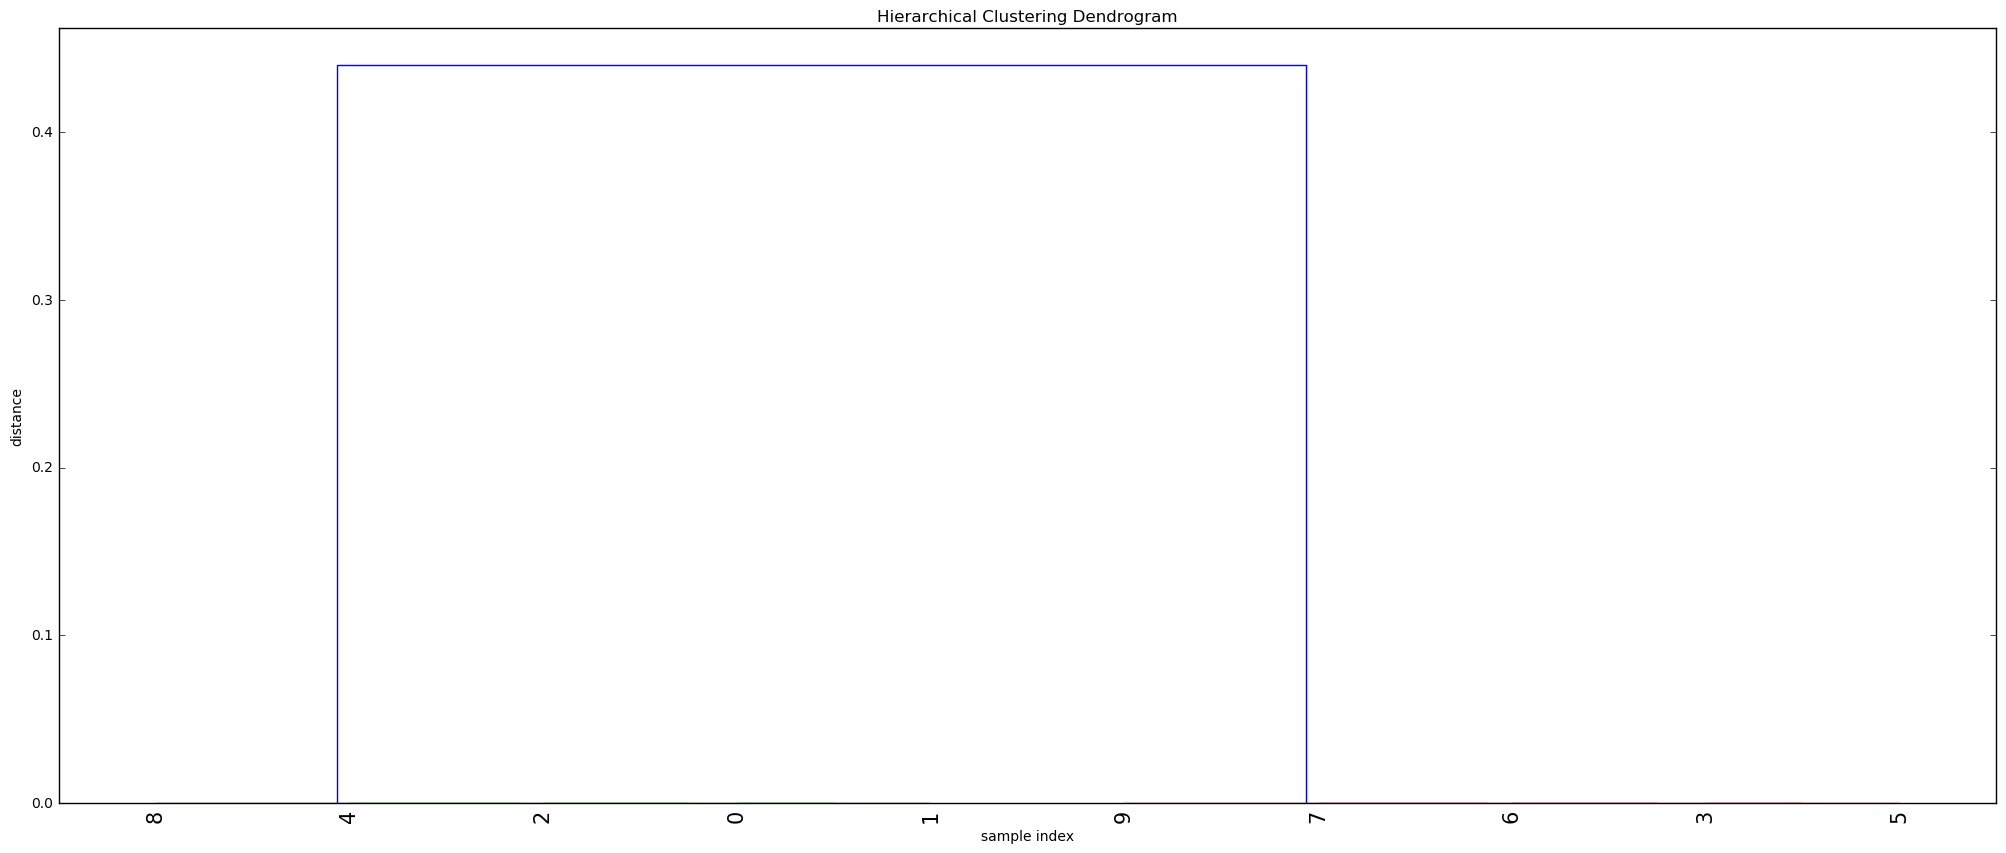

id| True | Pred | Sentence
 0 | 0    | 0    | ['pear', 'tomato', 'share2', 'grape', 'share1', 'share2', 'tomato', 'tomato', 'pear', 'grape', 'strawberry', 'grape', 'share2']
 1 | 0    | 0    | ['share2', 'share1', 'tomato', 'strawberry', 'grape', 'pear']
 2 | 0    | 0    | ['apple', 'strawberry', 'pear', 'apple', 'share1', 'share2', 'apple', 'apple', 'grape', 'apple']
 3 | 1    | 1    | ['lake', 'hill', 'valley', 'lake', 'share1', 'valley', 'share2', 'share1', 'share2', 'share1']
 4 | 0    | 0    | ['grape', 'share2', 'tomato', 'pear', 'apple', 'strawberry', 'strawberry', 'tomato']
 5 | 1    | 1    | ['valley', 'hill', 'hill', 'mountain', 'mountain', 'lake', 'share1', 'river', 'mountain', 'river', 'mountain']
 6 | 1    | 1    | ['hill', 'river', 'share2', 'share1', 'hill', 'lake', 'mountain', 'valley', 'river']
 7 | 1    | 1    | ['mountain', 'hill', 'lake', 'share1', 'mountain', 'mountain', 'valley', 'mountain', 'mountain', 'share1', 'share1']
 8 | 0    | 0    | ['share1', 'strawberry

In [104]:
demo_evaluate(*get_rand_mixture())

In [98]:
rand_evaluate()

Average accuracy of 1000 samples = 0.8031999999999999


In [99]:
# import cProfile
# dm, dl = get_rand_mixture()
# cProfile.run('demo_evaluate(dm,dl)')